In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [26]:
# Load data
df = pd.read_csv("./weatherAUS.csv")

In [29]:
print(f"Initial dataset shape: {df.shape}")
print("\nTarget variable (RainTomorrow) distribution:")
if 'RainTomorrow' in df.columns:
    print(df['RainTomorrow'].value_counts())
    print(f"Missing values in RainTomorrow: {df['RainTomorrow'].isnull().sum()}")
else:
    print("RainTomorrow column not found in dataset")

Initial dataset shape: (145460, 28)

Target variable (RainTomorrow) distribution:
RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64
Missing values in RainTomorrow: 3267


In [30]:
# Data Preprocessing
# Handling dates
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Season'] = pd.cut(df['Month'],
                     bins=[0,3,6,9,12],
                     labels=['Summer','Autumn','Winter','Spring'])

In [31]:
print("\nPerforming advanced feature engineering...")

# Basic meteorological features
if 'Humidity9am' in df.columns and 'Humidity3pm' in df.columns:
    df['HumidityDiff'] = df['Humidity9am'] - df['Humidity3pm']
    df['HumidityMean'] = (df['Humidity9am'] + df['Humidity3pm']) / 2

if 'Temp9am' in df.columns and 'Temp3pm' in df.columns:
    df['TempDiff'] = df['Temp3pm'] - df['Temp9am']
    df['TempRate'] = df['TempDiff'] / 6  # ~6 hours between measurements
    df['TempMean'] = (df['Temp9am'] + df['Temp3pm']) / 2

if 'Pressure9am' in df.columns and 'Pressure3pm' in df.columns:
    df['PressureDiff'] = df['Pressure9am'] - df['Pressure3pm']
    df['PressureMean'] = (df['Pressure9am'] + df['Pressure3pm']) / 2

# Advanced meteorological interactions
if 'Rainfall' in df.columns:
    df['RainfallSquared'] = df['Rainfall'] ** 2
    df['RainfallBinary'] = (df['Rainfall'] > 1).astype(int)

# Wind features
if all(col in df.columns for col in ['WindSpeed9am', 'WindSpeed3pm']):
    df['WindSpeedChange'] = df['WindSpeed3pm'] - df['WindSpeed9am']
    df['WindSpeedMean'] = (df['WindSpeed9am'] + df['WindSpeed3pm']) / 2

# Pressure-humidity interactions
if all(col in df.columns for col in ['Pressure9am', 'Humidity9am']):
    df['Pressure_Humidity_9am'] = df['Pressure9am'] * df['Humidity9am'] / 100
    
if all(col in df.columns for col in ['Pressure3pm', 'Humidity3pm']):
    df['Pressure_Humidity_3pm'] = df['Pressure3pm'] * df['Humidity3pm'] / 100

# Temperature-humidity interactions
if all(col in df.columns for col in ['Temp9am', 'Humidity9am']):
    df['Temp_Humidity_9am'] = df['Temp9am'] * df['Humidity9am'] / 100
    
if all(col in df.columns for col in ['Temp3pm', 'Humidity3pm']):
    df['Temp_Humidity_3pm'] = df['Temp3pm'] * df['Humidity3pm'] / 100

# Create climate zones based on location rainfall patterns
if 'Location' in df.columns:
    # Calculate average rainfall by location 
    location_avg_rain = df.groupby('Location')['Rainfall'].mean().reset_index()
    location_rain_dict = dict(zip(location_avg_rain['Location'], location_avg_rain['Rainfall']))
    
    # Map to create climate zone feature
    df['AvgLocationRainfall'] = df['Location'].map(location_rain_dict)
    
    # Create climate zones
    df['ClimateZone'] = pd.cut(
        df['AvgLocationRainfall'],
        bins=[0, 1, 2, 5, 10, float('inf')],
        labels=['Very Dry', 'Dry', 'Moderate', 'Wet', 'Very Wet']
    )



Performing advanced feature engineering...


In [32]:
# Drop Date column
df = df.drop('Date', axis=1)

In [33]:
# Encode categorical target variables
print("\nEncoding categorical target variables...")
if 'RainTomorrow' in df.columns:
    df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})
    print("Target distribution after encoding:")
    print(df['RainTomorrow'].value_counts(dropna=False))

if 'RainToday' in df.columns:
    df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})


Encoding categorical target variables...
Target distribution after encoding:
RainTomorrow
0.0    110316
1.0     31877
NaN      3267
Name: count, dtype: int64


In [34]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0].sort_values(ascending=False))

Missing values in each column:
Sunshine                 69835
Evaporation              62790
Cloud3pm                 59358
Cloud9am                 55888
Pressure_Humidity_3pm    17350
Pressure_Humidity_9am    16102
PressureMean             15289
PressureDiff             15289
Pressure9am              15065
Pressure3pm              15028
WindDir9am               10566
WindGustDir              10326
WindGustSpeed            10263
HumidityMean              5274
HumidityDiff              5274
Temp_Humidity_3pm         4507
Humidity3pm               4507
TempDiff                  4247
TempRate                  4247
TempMean                  4247
WindDir3pm                4228
WindSpeedChange           3616
WindSpeedMean             3616
Temp3pm                   3609
RainTomorrow              3267
RainToday                 3261
Rainfall                  3261
RainfallSquared           3261
WindSpeed3pm              3062
Humidity9am               2654
Temp_Humidity_9am         2654
Temp9am 

In [35]:
# Separate features and target early to avoid bias in imputation
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

In [36]:
# Handle missing values in target first
nan_mask = y.isnull()
print(f"\nRemoving {nan_mask.sum()} rows with missing target values")
X = X[~nan_mask]
y = y[~nan_mask]


Removing 3267 rows with missing target values


In [37]:
print(f"Dataset shape: {X.shape}")
print("Target distribution:")
print(y.value_counts(normalize=True) * 100)

Dataset shape: (142193, 43)
Target distribution:
RainTomorrow
0.0    77.581878
1.0    22.418122
Name: proportion, dtype: float64


In [38]:
# Get numeric columns, excluding target
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    if X[col].notnull().sum() > 0:  
        mean = X[col].mean()
        std = X[col].std()
        # Cap values at 3 standard deviations from mean
        X[col] = X[col].clip(lower=mean - 3*std, upper=mean + 3*std)

print("Outliers capped at 3 standard deviations from mean")
print(f"Dataset shape after outlier handling: {X.shape}")


Outliers capped at 3 standard deviations from mean
Dataset shape after outlier handling: (142193, 43)


In [41]:
# Use stratified sampling to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Training set: (113754, 43)
Test set: (28439, 43)


In [40]:
# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric features ({len(numeric_features)}): {numeric_features[:5]}...")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")


Numeric features (32): ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine']...
Categorical features (4): ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


In [42]:
# Use stratified sampling to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print("Training set target distribution:")
print(y_train.value_counts(normalize=True) * 100)


Training set: (113754, 43)
Test set: (28439, 43)
Training set target distribution:
RainTomorrow
0.0    77.581448
1.0    22.418552
Name: proportion, dtype: float64


In [43]:
# Check for missing values in the training set
missing_train = X_train.isnull().sum()
print("\nMissing values in training set (top 10):")
print(missing_train[missing_train > 0].sort_values(ascending=False).head(10))


Missing values in training set (top 10):
Sunshine                 54344
Evaporation              48695
Cloud3pm                 45669
Cloud9am                 42877
Pressure_Humidity_3pm    13066
Pressure_Humidity_9am    12077
PressureMean             11436
PressureDiff             11436
Pressure9am              11287
Pressure3pm              11262
dtype: int64


In [44]:
# Numeric transformer with KNN imputation
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5, weights='distance')),
    ('scaler', StandardScaler())
])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [45]:
# Initial preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training set shape: {X_train_processed.shape}")
print(f"Processed test set shape: {X_test_processed.shape}")


Processed training set shape: (113754, 129)
Processed test set shape: (28439, 129)


In [46]:
# Get feature names
onehot_feature_names = []
if categorical_features:
    onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.append(numeric_features, onehot_feature_names)

In [47]:
# Base estimator for feature selection - using a decision tree
feature_selector = SelectFromModel(
    DecisionTreeClassifier(max_depth=10, random_state=42), 
    threshold='median'  # Less aggressive than 'mean'
)
feature_selector.fit(X_train_processed, y_train)

# Apply feature selection
X_train_selected = feature_selector.transform(X_train_processed)
X_test_selected = feature_selector.transform(X_test_processed)

# Get selected feature mask and names
feature_mask = feature_selector.get_support()
selected_features = all_feature_names[feature_mask]
print(f"Selected {X_train_selected.shape[1]} features out of {X_train_processed.shape[1]}")
print(f"Top selected features: {selected_features[:10]}...")

Selected 65 features out of 129
Top selected features: ['MinTemp' 'MaxTemp' 'Rainfall' 'Evaporation' 'Sunshine' 'WindGustSpeed'
 'WindSpeed9am' 'WindSpeed3pm' 'Humidity9am' 'Humidity3pm']...


In [48]:
print("\nClass distribution before SMOTE:")
print(pd.Series(y_train).value_counts(normalize=True) * 100)


Class distribution before SMOTE:
RainTomorrow
0.0    77.581448
1.0    22.418552
Name: proportion, dtype: float64


In [49]:
# Check number of classes before applying SMOTE
n_classes = len(np.unique(y_train))
print(f"Number of classes in y_train: {n_classes}")

Number of classes in y_train: 2


In [51]:
smote = SMOTE(sampling_strategy=0.35, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_selected, y_train)
        
print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts(normalize=True) * 100)


Class distribution after SMOTE:
RainTomorrow
0.0    74.074198
1.0    25.925802
Name: proportion, dtype: float64


In [52]:
print("\n===== ADABOOST MODEL TRAINING =====")

# Define base estimator
base_estimator = DecisionTreeClassifier(
    max_depth=3, 
    random_state=42
)

# Define hyperparameter space for AdaBoost
param_dist = {
    'base_estimator__criterion': ['gini', 'entropy'],
    'base_estimator__max_depth': [1, 2, 3],  # Keep trees shallow for AdaBoost
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}



===== ADABOOST MODEL TRAINING =====


In [54]:
# Define base estimator (weak learner)
base_estimator = DecisionTreeClassifier(
    max_depth=3,  # Shallow trees are typically used as weak learners
    random_state=42
)

# Define hyperparameter space for AdaBoost
param_dist = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [1, 2, 3],  # Keep trees shallow for AdaBoost
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

In [56]:
# Use stratified cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize AdaBoost model
ada_model = AdaBoostClassifier(
    base_estimator,
    random_state=42
)

# RandomizedSearchCV with balanced_accuracy scoring
random_search = RandomizedSearchCV(
    estimator=ada_model,
    param_distributions=param_dist,
    n_iter=20,  # Reduced from 30 to speed up
    cv=cv_strategy,
    scoring='balanced_accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train the model
print("\nPerforming hyperparameter search...")
random_search.fit(X_resampled, y_resampled)


Performing hyperparameter search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                                                 random_state=42),
                                                random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'estimator__criterion': ['gini',
                                                                 'entropy'],
                                        'estimator__max_depth': [1, 2, 3],
                                        'learning_rate': [0.01, 0.1, 0.5, 1.0],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='balanced_accuracy', verbose=1)

In [57]:
# Get best model
best_ada_model = random_search.best_estimator_
print("\nBest hyperparameters:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")


Best hyperparameters:
n_estimators: 100
learning_rate: 1.0
estimator__max_depth: 2
estimator__criterion: gini
algorithm: SAMME.R


In [60]:
print("Creating ensemble of AdaBoost models...")

# Create individual AdaBoost models with different parameters
ada1 = AdaBoostClassifier(
    DecisionTreeClassifier(
        criterion=random_search.best_params_['estimator__criterion'],
        max_depth=random_search.best_params_['estimator__max_depth'],
        random_state=42
    ),
    n_estimators=random_search.best_params_['n_estimators'],
    learning_rate=random_search.best_params_['learning_rate'],
    algorithm=random_search.best_params_['algorithm'],
    random_state=42
)

# Variant with more estimators
ada2 = AdaBoostClassifier(
    DecisionTreeClassifier(
        criterion='entropy' if random_search.best_params_['estimator__criterion'] == 'gini' else 'gini',
        max_depth=random_search.best_params_['estimator__max_depth'],
        random_state=43
    ), 
    n_estimators=int(random_search.best_params_['n_estimators'] * 1.5),  # 50% more estimators
    learning_rate=random_search.best_params_['learning_rate'] * 0.8,  # Slower learning rate
    algorithm=random_search.best_params_['algorithm'],
    random_state=43
)

# Variant with different learning rate
ada3 = AdaBoostClassifier(
    DecisionTreeClassifier(
        criterion=random_search.best_params_['estimator__criterion'],
        max_depth=random_search.best_params_['estimator__max_depth'] + 1 
                if random_search.best_params_['estimator__max_depth'] < 3 else 3,
        random_state=44
    ),
    n_estimators=random_search.best_params_['n_estimators'],
    learning_rate=min(1.0, random_search.best_params_['learning_rate'] * 1.2),  # Faster learning rate
    algorithm='SAMME' if random_search.best_params_['algorithm'] == 'SAMME.R' else 'SAMME.R',
    random_state=44
)

# Create voting ensemble
ensemble_model = VotingClassifier(
    estimators=[
        ('ada1', ada1),
        ('ada2', ada2),
        ('ada3', ada3),
        ('best_ada', best_ada_model)
    ],
    voting='soft'
)

Creating ensemble of AdaBoost models...


In [61]:
# Train the ensemble
print("\nTraining ensemble model...")
ensemble_model.fit(X_resampled, y_resampled)


Training ensemble model...


VotingClassifier(estimators=[('ada1',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                                                  random_state=42),
                                                 n_estimators=100,
                                                 random_state=42)),
                             ('ada2',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=2,
                                                                                  random_state=43),
                                                 learning_rate=0.8,
                                                 n_estimators=150,
                                                 random_state=43)),
                             ('ada3',
                              AdaBoostClassifier(algorithm='SAMME',
                                                 estimator=DecisionTreeClassifier(max_depth=3,
                                                                                  random_state=44),
                                                 n_estimators=100,
                                                 random_state=44)),
                             ('best_ada',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                                                  random_state=42),
                                                 n_estimators=100,
                                                 random_state=42))],
                 voting='soft')

In [62]:
print("Optimizing classification threshold...")

# Generate predictions from both models
y_pred_best_ada = best_ada_model.predict(X_test_selected)
y_prob_best_ada = best_ada_model.predict_proba(X_test_selected)[:, 1]

y_pred_ensemble = ensemble_model.predict(X_test_selected)
y_prob_ensemble = ensemble_model.predict_proba(X_test_selected)[:, 1]

# Find optimal threshold for ensemble model
thresholds = np.arange(0.3, 0.7, 0.02)
accuracy_scores = []
balanced_accuracy_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_prob_ensemble >= thresh).astype(int)
    accuracy_scores.append(accuracy_score(y_test, y_pred_thresh))
    balanced_accuracy_scores.append(balanced_accuracy_score(y_test, y_pred_thresh))

# Find optimal threshold
optimal_idx = np.argmax(accuracy_scores)  # Optimize for accuracy
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal threshold: {optimal_threshold:.2f} (accuracy: {accuracy_scores[optimal_idx]:.4f})")


Optimizing classification threshold...

Optimal threshold: 0.50 (accuracy: 0.8479)


In [63]:
# Apply optimal threshold
y_pred_optimal = (y_prob_ensemble >= optimal_threshold).astype(int)

In [64]:
# Function to display model metrics
def evaluate_model(y_true, y_pred, y_prob=None, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true, y_pred)
    
    print(f"\n--- {model_name} Performance ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    print("\nConfusion Matrix:")
    print(conf_mat)
    
    # If probabilities are provided, calculate ROC AUC
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        print(f"ROC AUC: {roc_auc:.4f}")
    
    return acc, bal_acc, conf_mat

In [65]:
# Evaluate best AdaBoost model
ada_acc, ada_bal_acc, ada_conf_mat = evaluate_model(
    y_test, y_pred_best_ada, y_prob_best_ada, "Best AdaBoost Model"
)


--- Best AdaBoost Model Performance ---
Accuracy: 0.8503
Balanced Accuracy: 0.7451

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     22064
         1.0       0.71      0.55      0.62      6375

    accuracy                           0.85     28439
   macro avg       0.80      0.75      0.77     28439
weighted avg       0.84      0.85      0.84     28439


Confusion Matrix:
[[20646  1418]
 [ 2840  3535]]
ROC AUC: 0.8823


In [66]:
# Evaluate ensemble model with default threshold
ens_acc, ens_bal_acc, ens_conf_mat = evaluate_model(
    y_test, y_pred_ensemble, y_prob_ensemble, "Ensemble Model (Default Threshold)"
)

# Evaluate ensemble model with optimal threshold
opt_acc, opt_bal_acc, opt_conf_mat = evaluate_model(
    y_test, y_pred_optimal, y_prob_ensemble, "Ensemble Model (Optimal Threshold)"
)



--- Ensemble Model (Default Threshold) Performance ---
Accuracy: 0.8479
Balanced Accuracy: 0.7437

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90     22064
         1.0       0.70      0.55      0.62      6375

    accuracy                           0.85     28439
   macro avg       0.79      0.74      0.76     28439
weighted avg       0.84      0.85      0.84     28439


Confusion Matrix:
[[20578  1486]
 [ 2839  3536]]
ROC AUC: 0.8786

--- Ensemble Model (Optimal Threshold) Performance ---
Accuracy: 0.8479
Balanced Accuracy: 0.7437

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90     22064
         1.0       0.70      0.55      0.62      6375

    accuracy                           0.85     28439
   macro avg       0.79      0.74      0.76     28439
weighted avg       0.84      0.85      0.84     28439


Confusion Matrix:
[[20578  1486]


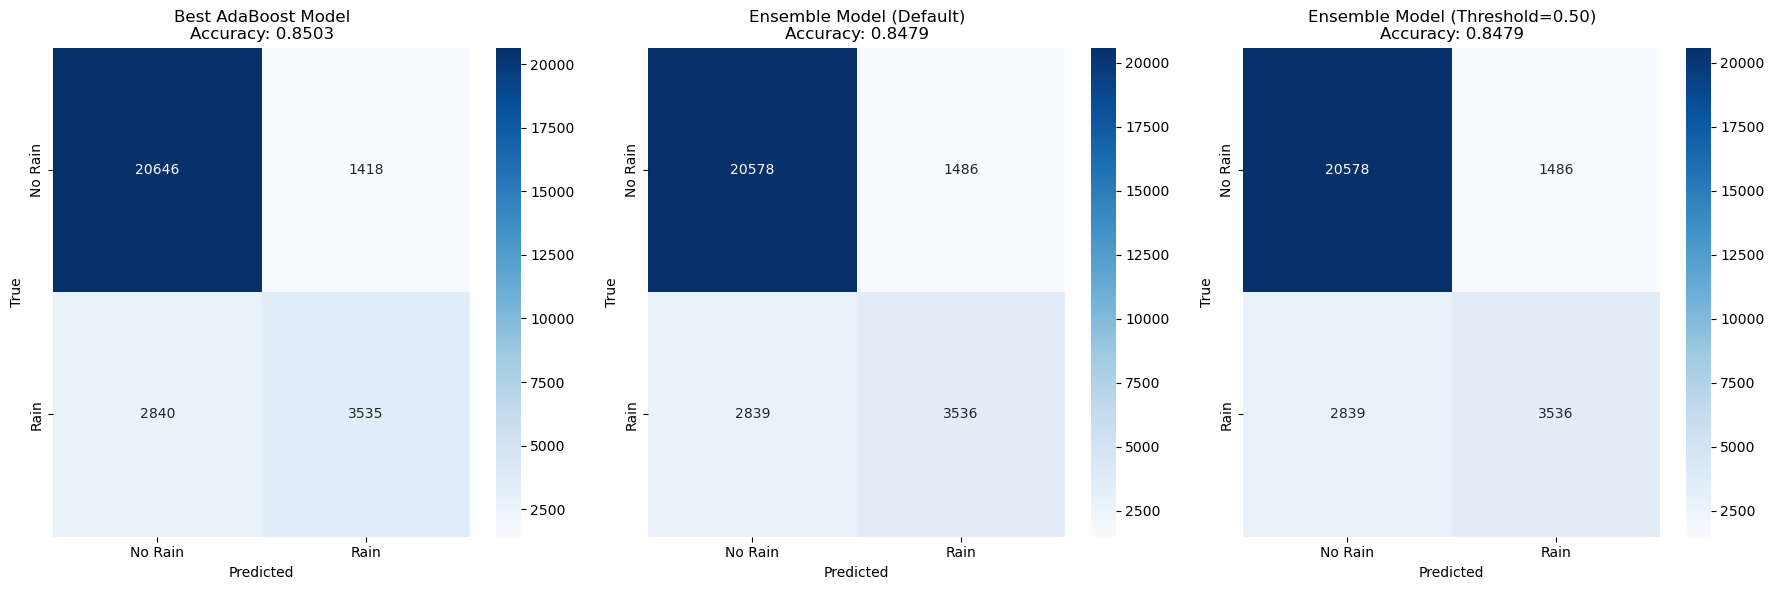

In [67]:
#Confusion Matrices Comparison
plt.figure(figsize=(18, 6))

# Calculate confusion matrices
ada_conf_mat = confusion_matrix(y_test, y_pred_best_ada)
ens_conf_mat = confusion_matrix(y_test, y_pred_ensemble)
opt_conf_mat = confusion_matrix(y_test, y_pred_optimal)

# Calculate accuracies
ada_acc = accuracy_score(y_test, y_pred_best_ada)
ens_acc = accuracy_score(y_test, y_pred_ensemble)
opt_acc = accuracy_score(y_test, y_pred_optimal)

plt.subplot(1, 3, 1)
sns.heatmap(ada_conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.title(f'Best AdaBoost Model\nAccuracy: {ada_acc:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 3, 2)
sns.heatmap(ens_conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.title(f'Ensemble Model (Default)\nAccuracy: {ens_acc:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 3, 3)
sns.heatmap(opt_conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.title(f'Ensemble Model (Threshold={optimal_threshold:.2f})\nAccuracy: {opt_acc:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

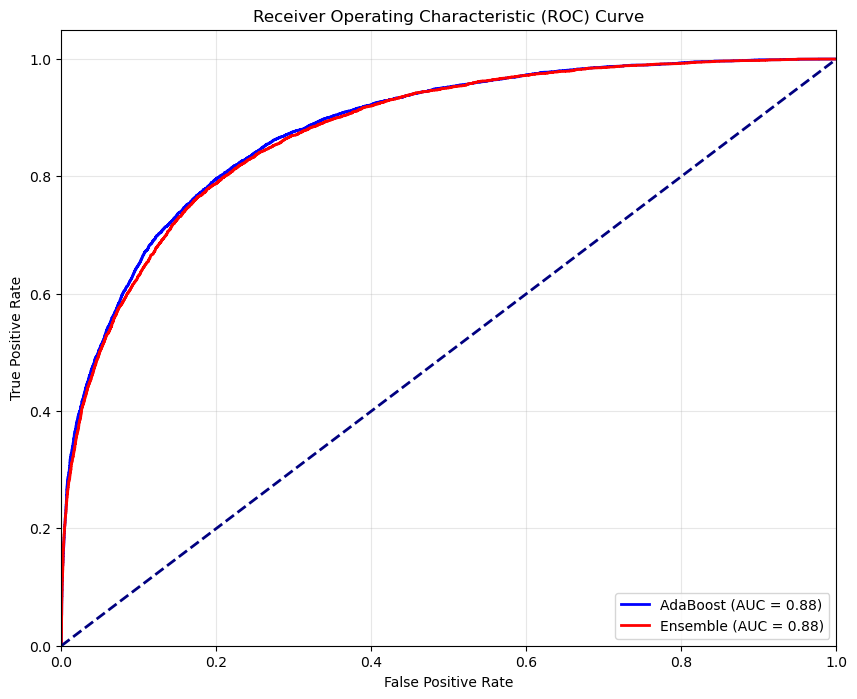

In [68]:
#ROC Curves
plt.figure(figsize=(10, 8))

# ROC for best AdaBoost model
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_prob_best_ada)
roc_auc_ada = auc(fpr_ada, tpr_ada)
plt.plot(fpr_ada, tpr_ada, color='blue', lw=2, 
         label=f'AdaBoost (AUC = {roc_auc_ada:.2f})')

# ROC for ensemble
fpr_ens, tpr_ens, _ = roc_curve(y_test, y_prob_ensemble)
roc_auc_ens = auc(fpr_ens, tpr_ens)
plt.plot(fpr_ens, tpr_ens, color='red', lw=2, 
         label=f'Ensemble (AUC = {roc_auc_ens:.2f})')

# Reference line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


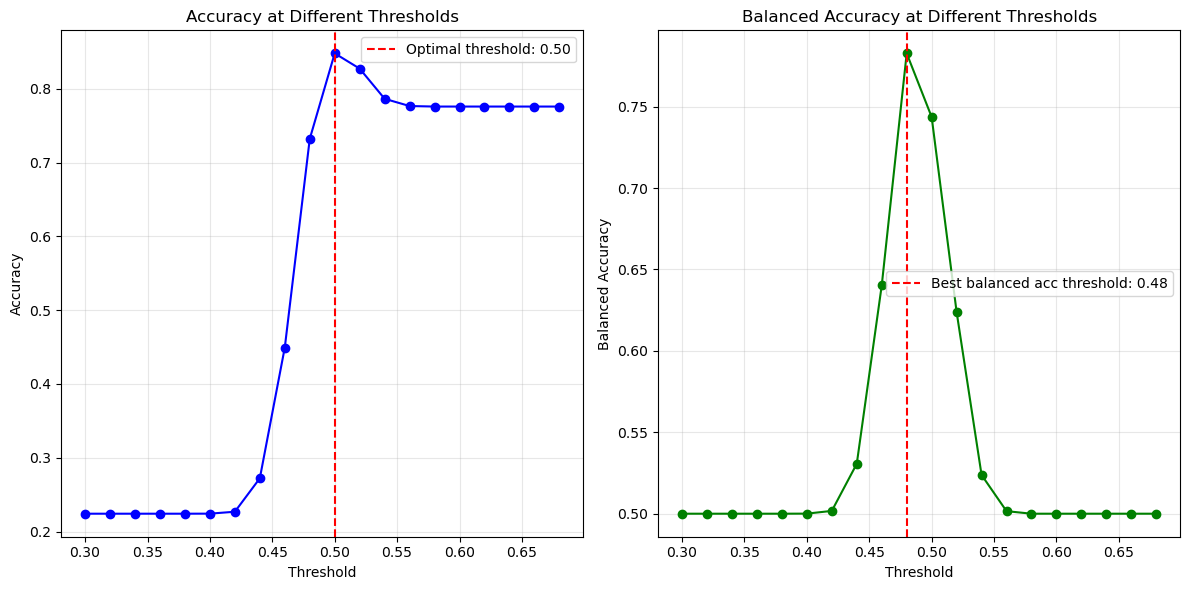

In [69]:
#Threshold Optimization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(thresholds, accuracy_scores, marker='o', color='blue', linestyle='-')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', 
           label=f'Optimal threshold: {optimal_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy at Different Thresholds')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(thresholds, balanced_accuracy_scores, marker='o', color='green', linestyle='-')
best_bal_acc_idx = np.argmax(balanced_accuracy_scores)
plt.axvline(x=thresholds[best_bal_acc_idx], color='red', linestyle='--',
           label=f'Best balanced acc threshold: {thresholds[best_bal_acc_idx]:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy at Different Thresholds')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


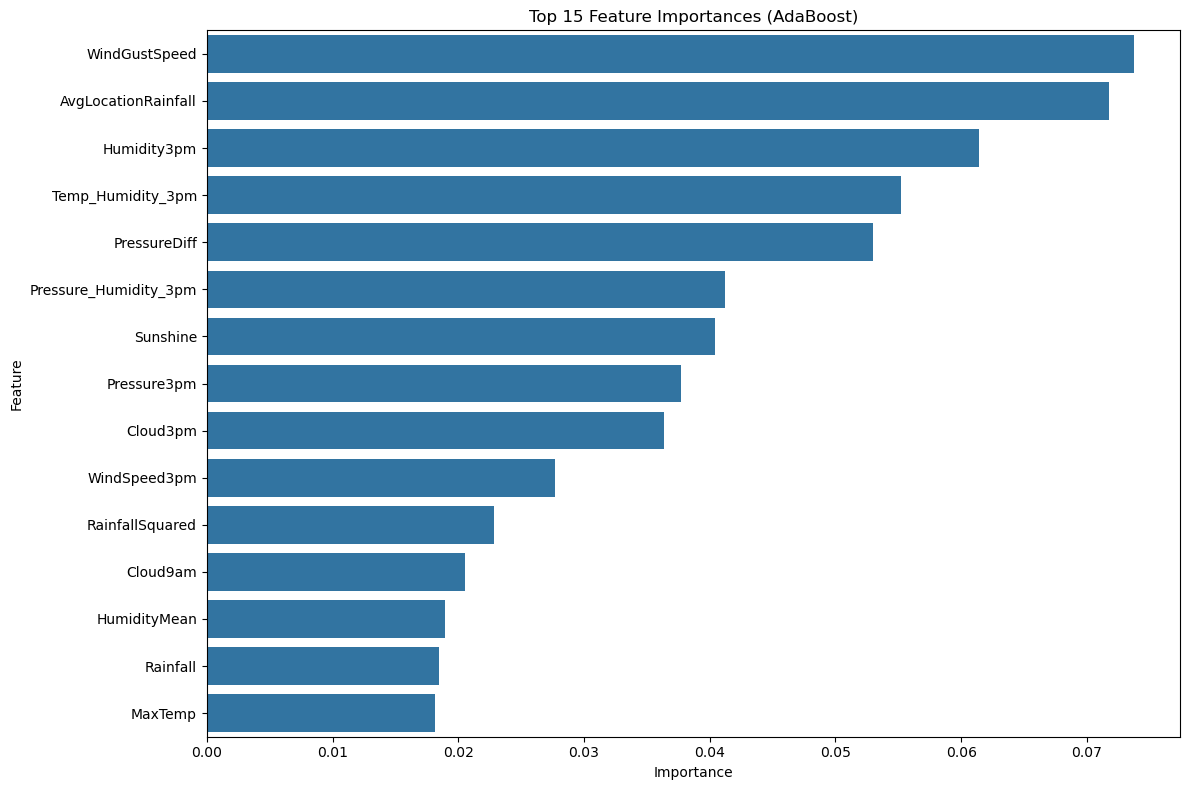


Top 10 most important features:
1. WindGustSpeed: 0.0737
2. AvgLocationRainfall: 0.0718
3. Humidity3pm: 0.0614
4. Temp_Humidity_3pm: 0.0552
5. PressureDiff: 0.0530
6. Pressure_Humidity_3pm: 0.0412
7. Sunshine: 0.0404
8. Pressure3pm: 0.0377
9. Cloud3pm: 0.0363
10. WindSpeed3pm: 0.0277


In [70]:
#Feature Importance for AdaBoost
if hasattr(best_ada_model, 'feature_importances_'):
    # Get feature importances
    importances = best_ada_model.feature_importances_
    
    # Create DataFrame for visualization
    feature_importance = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Feature Importances (AdaBoost)')
    plt.tight_layout()
    plt.show()

    # Print top features
    print("\nTop 10 most important features:")
    for i, (feature, importance) in enumerate(zip(feature_importance['Feature'].head(10), 
                                                feature_importance['Importance'].head(10))):
        print(f"{i+1}. {feature}: {importance:.4f}")